In [1]:
import cv2
import glob
import time
import locale
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt 

from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.python import keras
from keras.models import Model
from keras.layers import Flatten
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers import concatenate
from keras.layers.core import Dropout
from keras.callbacks import TensorBoard
from keras.models import model_from_yaml
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
#from keras.layers.normalization import BatchNormalization

Load the data:

In [2]:
#textfile_path = "C:\\Users\\HP\\Desktop\\Barcelona\\Term3\\DeepLearningApplication\\term_paper\\HousesDataset\\HousesInfo.txt"
textfile_path = "HousesDataset/HousesInfo.txt"

col = ["bedrooms", "bathrooms", "area", "zipcode", "price"]

text_data = pd.read_csv(textfile_path, sep = ' ', names = col)

text_data.head(10)

,bedrooms,bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226
5,4,5.0,4581,85266,1249000
6,3,4.0,2544,85262,799000
7,4,5.0,5524,85266,1698000
8,3,4.0,4229,85255,1749000
9,4,5.0,3550,85262,1500000


since house prices have a high magnitue we use the highest price to scale

In [3]:
p_max = text_data['price'].max()

In [4]:
y = text_data['price']
text_data = text_data.drop(columns='price', axis=1)

X = text_data

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=420)

The following two functions group the photos associated with an id into one. *image_split_lr()* produced a low resolution image while *image_split_hr()* produces a high resolution image. We hope differences in the MSE/R² can help to quantify the effect of visual features.

In [5]:
def image_split_lr(df):
    images = []

    for i in df.index.values:
        housePaths = sorted(list(glob.glob("HousesDataset/{}_*".format(i+1))))

        inputImages = []
        outputImage = np.zeros((64,64,3), dtype = "uint8")
                
        for housePath in housePaths : 
            image = cv2.imread(housePath)
            image = cv2.resize(image,(32,32), interpolation = cv2.INTER_CUBIC)
            inputImages.append(image)

            if len(inputImages) >= 4: 
                outputImage[0:32, 0:32] = inputImages[0]
                outputImage[0:32, 32:64] = inputImages[1]
                outputImage[32:64, 32:64] = inputImages[2]
                outputImage[32:64, 0:32] = inputImages[3]
                images.append(outputImage)

    return images

In [6]:
def image_split_hr(df):
    images = []

    for i in df.index.values:
        housePaths = sorted(list(glob.glob("HousesDataset/{}_*".format(i+1))))

        inputImages = []
        outputImage = np.zeros((256, 256, 3), dtype = "uint8")
                
        for housePath in housePaths : 
            image = cv2.imread(housePath)
            image = cv2.resize(image, (128, 128), interpolation = cv2.INTER_CUBIC)
            inputImages.append(image)

            if len(inputImages) >= 4: 
                outputImage[0:128, 0:128] = inputImages[0]
                outputImage[0:128, 128:256] = inputImages[1]
                outputImage[128:256, 128:256] = inputImages[2]
                outputImage[128:256, 0:128] = inputImages[3]
            
                images.append(outputImage)

    return images


In [7]:
X_train_img_lr = image_split_lr(y_train)
X_test_img_lr = image_split_lr(y_test)

X_train_img_hr = image_split_hr(y_train)
X_test_img_hr = image_split_hr(y_test)

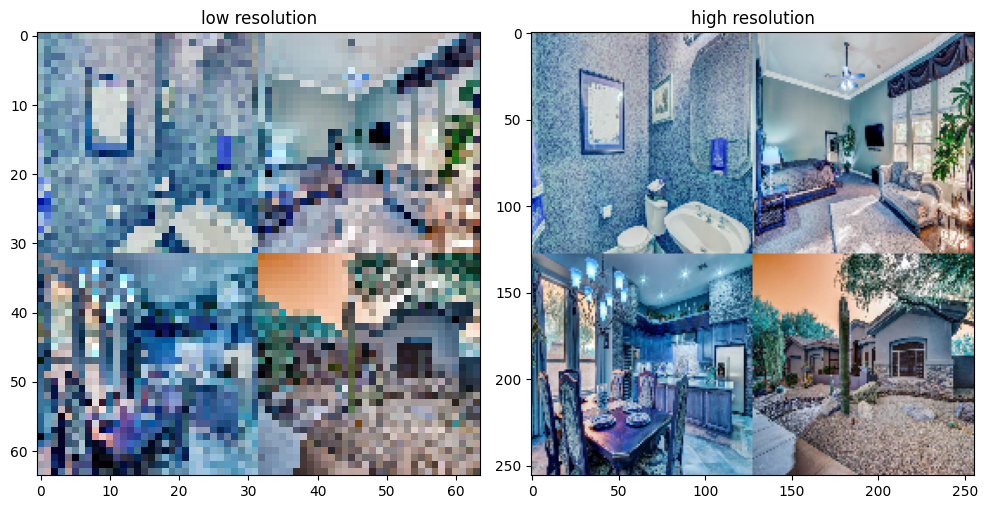

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(X_train_img_lr[1])
axs[0].set_title('low resolution')

axs[1].imshow(X_train_img_hr[1])
axs[1].set_title('high resolution')

plt.tight_layout()

plt.show()

In [9]:
# standarise images
X_train_img_lr = np.multiply(X_train_img_lr, (1/255))
X_test_img_lr = np.multiply(X_test_img_lr, (1/255))

X_train_img_hr = np.multiply(X_train_img_hr, (1/255))
X_test_img_hr = np.multiply(X_test_img_hr, (1/255))

# y is the price of the house corresponding to house i
y_train = np.stack(y_train)
y_train = y_train / p_max
y_test = np.stack(y_test)
y_test = y_test / p_max

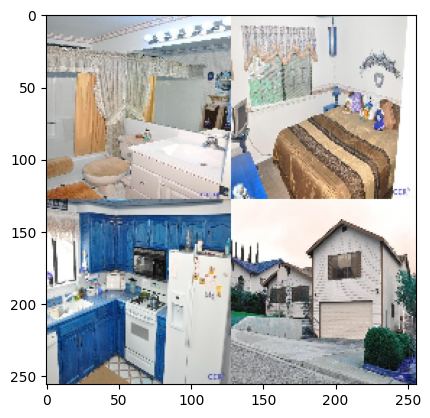

In [10]:
# visualisation pt. II
plt.imshow(X_test_img_hr[3])
plt.show()

In [11]:
print(X_test_img_lr[0])

[[[0.97647059 0.97647059 0.97647059]
  [0.97254902 0.97254902 0.97254902]
  [0.98039216 0.98039216 0.98039216]
  ...
  [0.18039216 0.2627451  0.50588235]
  [0.20784314 0.28627451 0.50588235]
  [0.25490196 0.38823529 0.64313725]]

 [[0.99215686 0.98823529 0.99215686]
  [0.99215686 0.98431373 0.98431373]
  [0.98431373 0.98431373 0.98431373]
  ...
  [0.18431373 0.2627451  0.49019608]
  [0.19215686 0.27058824 0.48235294]
  [0.25098039 0.37647059 0.63529412]]

 [[0.61568627 0.76470588 0.84705882]
  [0.80392157 0.85490196 0.87058824]
  [0.95686275 0.96078431 0.95294118]
  ...
  [0.18823529 0.2745098  0.50588235]
  [0.18823529 0.26666667 0.45098039]
  [0.17254902 0.25882353 0.44313725]]

 ...

 [[0.61176471 0.72156863 0.83529412]
  [0.61176471 0.7254902  0.83137255]
  [0.59215686 0.71372549 0.83529412]
  ...
  [0.65882353 0.81176471 0.96862745]
  [0.59607843 0.74509804 0.9372549 ]
  [0.18431373 0.38039216 0.56862745]]

 [[0.61568627 0.72941176 0.83529412]
  [0.60784314 0.72156863 0.82745098]


In [12]:
# check dimensions:
print(f'{X_train_img_lr.shape} is the dimension of the training images (lr)')
print(f'{X_train_img_hr.shape} is the dimension of the training images (hr)')
print(f'{X_train.shape} is the dimension of the training data')
print(f'{y_train.shape} is the dimension of y train')

print(f'{X_test_img_lr.shape} is the dimension of the testing images (lr)')
print(f'{X_test_img_hr.shape} is the dimension of the testing images (hr)')
print(f'{X_test.shape} is the dimension of the testing data')
print(f'{y_test.shape} is the dimension of y test')

(481, 64, 64, 3) is the dimension of the training images (lr)
(481, 256, 256, 3) is the dimension of the training images (hr)
(481, 4) is the dimension of the training data
(481,) is the dimension of y train
(54, 64, 64, 3) is the dimension of the testing images (lr)
(54, 256, 256, 3) is the dimension of the testing images (hr)
(54, 4) is the dimension of the testing data
(54,) is the dimension of y test


In [13]:
print(X_train.isna().sum())
print(X_test.isna().sum())

bedrooms     0
bathrooms    0
area         0
zipcode      0
dtype: int64
bedrooms     0
bathrooms    0
area         0
zipcode      0
dtype: int64


In [14]:
def standardise_df(df, df_test):

    scaler = MinMaxScaler()

    df_standardized = scaler.fit_transform(df)
    df_standardized_test = scaler.transform(df_test)

    return df_standardized, df_standardized_test

In [15]:
X_train, X_test = standardise_df(X_train, X_test)

### Model
1. Build Baseline Model (Neural Network for tabular data)
2. Build Low Resolution Model
3. Build High Resolution Model

In [16]:
baseline = Sequential()
baseline.add(Dropout(0.2, input_shape=(4,)))
baseline.add(Dense(16, activation='relu'))
baseline.add(Dense(4, activation='relu'))
baseline.add(Dense(1, activation='linear'))
baseline.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
history_baseline = baseline.fit(X_train, y_train, epochs = 30, batch_size = 32, 
                    #validation_data=([X_val, X_val_img], y_val), 
                    callbacks=[early_stopping], validation_split = (1/9))

Epoch 1/30
14/14 [==============================] - 1s 17ms/step - loss: 0.0577 - mean_squared_error: 0.0577 - val_loss: 0.0235 - val_mean_squared_error: 0.0235
Epoch 2/30
14/14 [==============================] - 0s 4ms/step - loss: 0.0263 - mean_squared_error: 0.0263 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 3/30
14/14 [==============================] - 0s 4ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 4/30
14/14 [==============================] - 0s 4ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 5/30
14/14 [==============================] - 0s 4ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 6/30
14/14 [==============================] - 0s 4ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 7/30
14/14 [=====================

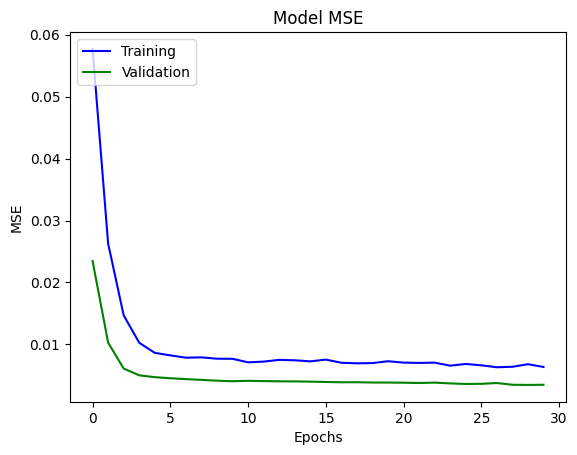

In [18]:
plt.plot(history_baseline.history['loss'], color='b')
plt.plot(history_baseline.history['val_loss'], color='g')

plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epochs')

plt.legend(['Training', 'Validation'], loc='upper left')

plt.show()

In [19]:
predictions_baseline = baseline.predict(X_test)

2/2 [==============================] - 0s 3ms/step


In [20]:
error = predictions_baseline.flatten() - y_test
squared_error = error ** 2
MSE_baseline = np.mean(squared_error)
print(MSE_baseline)

0.003506106794173581


In [21]:
# neural network for tabular data

def tabular_nn():
    nn = Sequential()
    nn.add(Dropout(0.2, input_shape=(4,)))
    nn.add(Dense(16, activation='relu'))
    nn.add(Dense(4, activation='relu'))
    return nn

In [22]:
# convolutional neural network for images
def cnn(size):
    # takes the dimesion as arguement, eg. (256,256,3) or (64, 64, 3)
    model = Sequential()

    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=size))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(16, activation='relu'))
    model.add(Dense(4, activation='relu'))

    return model

In [23]:
tabular_model = tabular_nn()
cnn_model_lr = cnn((64, 64, 3))
cnn_model_hr = cnn((256, 256, 3))

2. low resolution:

In [24]:
merged_lr = concatenate([tabular_model.output, cnn_model_lr.output])

final_dense_lr = Dense(4, activation='relu')(merged_lr)
output_lr = Dense(1)(final_dense_lr)

model_lr = Model(inputs=[tabular_model.input, cnn_model_lr.input], outputs=output_lr)
model_lr.compile(optimizer='adam', loss='mse')

In [25]:
history_lr = model_lr.fit([X_train, X_train_img_lr], y_train, epochs = 30, batch_size = 32, 
                    #validation_data=([X_val, X_val_img], y_val), 
                    callbacks=[early_stopping], validation_split = (1/9))

Epoch 1/30
14/14 [==============================] - 2s 63ms/step - loss: 0.0311 - val_loss: 0.0065
Epoch 2/30
14/14 [==============================] - 1s 52ms/step - loss: 0.0110 - val_loss: 0.0056
Epoch 3/30
14/14 [==============================] - 1s 50ms/step - loss: 0.0101 - val_loss: 0.0055
Epoch 4/30
14/14 [==============================] - 1s 51ms/step - loss: 0.0095 - val_loss: 0.0049
Epoch 5/30
14/14 [==============================] - 1s 51ms/step - loss: 0.0082 - val_loss: 0.0047
Epoch 6/30
14/14 [==============================] - 1s 54ms/step - loss: 0.0078 - val_loss: 0.0047
Epoch 7/30
14/14 [==============================] - 1s 60ms/step - loss: 0.0074 - val_loss: 0.0045
Epoch 8/30
14/14 [==============================] - 1s 56ms/step - loss: 0.0076 - val_loss: 0.0044
Epoch 9/30
14/14 [==============================] - 1s 56ms/step - loss: 0.0072 - val_loss: 0.0043
Epoch 10/30
14/14 [==============================] - 1s 54ms/step - loss: 0.0069 - val_loss: 0.0044
Epoch 11/

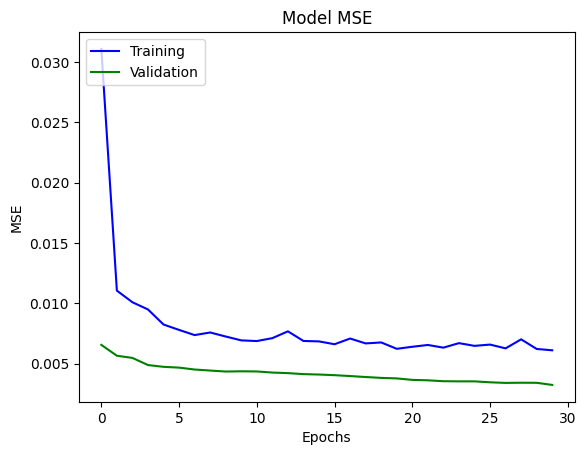

In [26]:
plt.plot(history_lr.history['loss'], color='b')
plt.plot(history_lr.history['val_loss'], color='g')

plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epochs')

plt.legend(['Training', 'Validation'], loc='upper left')

plt.show()

In [27]:
predictions_lr = model_lr.predict([X_test, X_test_img_lr])

2/2 [==============================] - 0s 9ms/step


In [28]:
# MSE
error = predictions_lr.flatten() - y_test
squared_error = error ** 2
MSE_lr = np.mean(squared_error)
print(MSE_lr)

0.002960148219223463


3. high resolution:

In [29]:
merged_hr = concatenate([tabular_model.output, cnn_model_hr.output])

final_dense_hr = Dense(4, activation='relu')(merged_hr)
output_hr = Dense(1)(final_dense_hr)

model_hr = Model(inputs=[tabular_model.input, cnn_model_hr.input], outputs=output_hr)
model_hr.compile(optimizer='adam', loss='mse')

In [30]:
history_hr = model_hr.fit([X_train, X_train_img_hr], y_train, epochs = 30, batch_size = 32, 
                    #validation_data=([X_val, X_val_img], y_val), 
                    callbacks=[early_stopping], validation_split = (1/9))

Epoch 1/30
14/14 [==============================] - 17s 1s/step - loss: 0.1837 - val_loss: 0.0170
Epoch 2/30
14/14 [==============================] - 16s 1s/step - loss: 0.0246 - val_loss: 0.0148
Epoch 3/30
14/14 [==============================] - 17s 1s/step - loss: 0.0192 - val_loss: 0.0115
Epoch 4/30
14/14 [==============================] - 13s 878ms/step - loss: 0.0168 - val_loss: 0.0102
Epoch 5/30
14/14 [==============================] - 11s 783ms/step - loss: 0.0148 - val_loss: 0.0095
Epoch 6/30
14/14 [==============================] - 11s 786ms/step - loss: 0.0139 - val_loss: 0.0092
Epoch 7/30
14/14 [==============================] - 11s 800ms/step - loss: 0.0128 - val_loss: 0.0076
Epoch 8/30
14/14 [==============================] - 13s 933ms/step - loss: 0.0120 - val_loss: 0.0071
Epoch 9/30
14/14 [==============================] - 12s 850ms/step - loss: 0.0110 - val_loss: 0.0068
Epoch 10/30
14/14 [==============================] - 12s 825ms/step - loss: 0.0105 - val_loss: 0.006

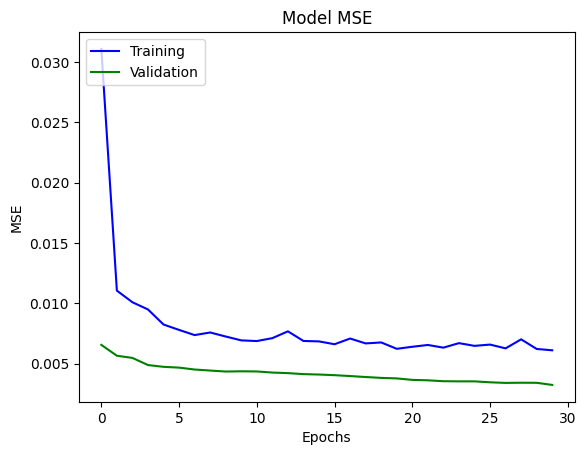

In [31]:
plt.plot(history_lr.history['loss'], color='b')
plt.plot(history_lr.history['val_loss'], color='g')

plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epochs')

plt.legend(['Training', 'Validation'], loc='upper left')

plt.show()

In [32]:
predictions_hr = model_hr.predict([X_test, X_test_img_hr])

2/2 [==============================] - 1s 162ms/step


In [33]:
error = predictions_hr.flatten() - y_test
squared_error = error ** 2
MSE_hr = np.mean(squared_error)
print(MSE_hr)

0.0032405706831753426


Model Comparison

In [36]:
index = ['Baseline', 'Low Resolution', 'High Resolution']
data = [MSE_baseline, MSE_lr, MSE_hr]

results = pd.DataFrame(data, index=index, columns=['MSE'])

In [37]:
results

,MSE
Baseline,0.003506
Low Resolution,0.002960
High Resolution,0.003241
